## Import Libraries

In [1]:
from glob import glob
from time import time
from random import randrange
from functools import reduce
import pandas as pd
import numpy as np
import df_plot_prep as pp
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score

## Import Data

In [194]:
#df = pd.read_csv('input_data/goodreads_books.csv') 

In [42]:
files = glob("input_data/goodreads_books_chunk_*.csv")

list_df = []

for filename in files:
    df = pd.read_csv(filename, index_col=None, header=0)
    list_df.append(df)

df = pd.concat(list_df, axis=0, ignore_index=True)

In [3]:
df.head()

,id,title,link,series,cover_link,author,author_link,rating_count,review_count,average_rating,...,isbn13,asin,settings,characters,awards,amazon_redirect_link,worldcat_redirect_link,recommended_books,books_in_series,description
0,630104,Inner Circle,https://www.goodreads.com//book/show/630104.In...,(Private #5),https://i.gr-assets.com/images/S/compressed.ph...,"Kate Brian, Julian Peploe",https://www.goodreads.com/author/show/94091.Ka...,7597,196,4.03,...,9781416950417,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"726458, 726458, 1537534, 3047848, 1651302, 304...","381489, 381501, 352428, 630103, 1783281, 17832...",Reed Brennan arrived at Easton Academy expecti...
1,9487,A Time to Embrace,https://www.goodreads.com//book/show/9487.A_Ti...,(Timeless Love #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,4179,177,4.35,...,9781595542328,NaN,NaN,NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"127352, 127352, 40642197, 127353, 127354, 3891...",115036,"Ideje az Ã¶lelÃ©snek TÃ¶rtÃ©net a remÃ©nyrÅl,..."
2,6050894,Take Two,https://www.goodreads.com//book/show/6050894-t...,(Above the Line #2),https://i.gr-assets.com/images/S/compressed.ph...,Karen Kingsbury,https://www.goodreads.com/author/show/3159984....,6288,218,4.23,...,NaN,NaN,"Bloomington, Indiana(United States)",NaN,NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"706250, 706250, 666481, 11942636, 706241, 1273...","4010795, 40792877, 7306261",Filmmakers Chase Ryan and Keith Ellison have c...
3,39030,Reliquary,https://www.goodreads.com//book/show/39030.Rel...,(Pendergast #2),https://i.gr-assets.com/images/S/compressed.ph...,"Douglas Preston, Lincoln Child",https://www.goodreads.com/author/show/12577.Do...,38382,1424,4.01,...,9780765354952,NaN,"New York State(United States) New York City, N...","Aloysius X.L. Pendergast, Margo Green, William...",NaN,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"39026, 39026, 11007668, 3986318, 51887330, 194...","67035, 39031, 39033, 136637, 136638, 30068, 39...",NaN
4,998,The Millionaire Next Door: The Surprising Secr...,https://www.goodreads.com//book/show/998.The_M...,NaN,https://i.gr-assets.com/images/S/compressed.ph...,"Thomas J. Stanley, William D. Danko",https://www.goodreads.com/author/show/659.Thom...,72168,3217,4.04,...,9780671015206,NaN,NaN,NaN,Independent Publisher Book Award (IPPY) Nomine...,https://www.goodreads.com//book_link/follow/17...,https://www.goodreads.com//book_link/follow/8?...,"1052, 1052, 763362, 69571, 78427, 30186948, 10...",NaN,The incredible national bestseller that is cha...


## Preprocessing

### Generating New Columns

In [43]:
#1 Create new column by how many authors the book was written. To this end, comma-separated units are counted.
col = 'author'
new_col_loc = df.columns.get_loc(col)+1
df.insert(new_col_loc, 'number_of_authors', df[col].str.count(',')+1)

#2 Create new column for the book's publication year.
col = 'date_published'
new_col_loc = df.columns.get_loc(col)+1
df.insert(new_col_loc, 'year_published', pd.to_numeric(df[col].str[-4:], errors = 'coerce'))

#3 Create new column if book is an award winning book (1) or not (0).
#  By this, missing values are treated as a valuable information itself (0 = book is not award winning).
#  Assuming the column 'awards' is reliably filled.
col = 'awards'
new_col_loc = df.columns.get_loc(col)+1
df.insert(new_col_loc, 'is_award_winning', df[col].notna().astype(int))

#4 Create new column for the number of books in the series. To this end, comma-separated units are counted.
#  Please note that the book at hand is not listed in the column 'books_in_series' (+2).
col = 'books_in_series'
new_col_loc = df.columns.get_loc(col)+1
df.insert(new_col_loc, 'number_of_books_in_series', df[col].str.count(',')+2) 

#5 Improve consistent representation of missing values in 'number_of_pages' (convert 0 to NaN).
col = 'number_of_pages'
df[col] = df[col].replace(0, np.nan)

#6 Create new column for the book's main genre according to readers' votes. 
#  To this end, the numerical votes are removed (genre mix) and the first comma-separated unit is extracted (main genre).
#  Inspection of the column 'genre_and_votes' reveals the most voted genre to be listed in the first position.
col = 'genre_and_votes'
new_col_loc = df.columns.get_loc(col)+1
df.insert(new_col_loc, 'main_genre', df[col].replace(to_replace=' [0-9]+', value='', regex=True).str.split(',').str[0])

#  Random sample (n=10).
random_int = randrange(start=0, stop=df.shape[0]-10)
print(df[col][random_int:random_int+10])

41408                                      Adventure 1user
41409                                                  NaN
41410                                        Fiction 1user
41411    Reference 11, How To 3, Nonfiction 3, Science-...
41412                                                  NaN
41413                                                  NaN
41414    Romance 20, Romance-Contemporary Romance 10, A...
41415    Westerns 11, Fiction 3, Romance 2, Animals-Hor...
41416    Romance-M M Romance 2, Adult Fiction-Erotica 1...
41417                                                  NaN
Name: genre_and_votes, dtype: object


### Overview of Missing Values

In [4]:
cols_wo_missing_vals = list(df.columns[df.isnull().sum()/df.shape[0] == 0])
cols_w_missing_vals = list(df.columns[df.isnull().sum()/df.shape[0] > 0])

print('List of columns without missing values: {}'.format(cols_wo_missing_vals))

List of columns without missing values: ['id', 'title', 'link', 'author', 'number_of_authors', 'author_link', 'rating_count', 'review_count', 'average_rating', 'five_star_ratings', 'four_star_ratings', 'three_star_ratings', 'two_star_ratings', 'one_star_ratings', 'is_award_winning', 'amazon_redirect_link']


In [5]:
cols_missing_vals_share = df[cols_w_missing_vals].isnull().sum()/df.shape[0]
pd.options.display.min_rows = 25

print(cols_missing_vals_share.sort_values(ascending = False))

asin                         0.899692
awards                       0.796433
settings                     0.779402
characters                   0.737639
books_in_series              0.577042
number_of_books_in_series    0.577042
series                       0.553267
original_title               0.248070
isbn13                       0.243146
isbn                         0.227648
recommended_books            0.076515
worldcat_redirect_link       0.076342
publisher                    0.069657
main_genre                   0.054407
genre_and_votes              0.054407
description                  0.049330
number_of_pages              0.047836
year_published               0.016610
date_published               0.016475
cover_link                   0.011629
dtype: float64


### Removing Columns
ID-related, descriptive and columns with a high proportion of missing values (where missing values are meaningless) are removed.

*Meaningful missing values: e.g. number_of_books_in_series - missing value means 0, book is not part of series. Meaningless missing values: e.g. settings - missing value can neither be interpreted nor replaced in a reasonable way.*

In [44]:
remove_cols_list = ['id','title','original_title','link','author_link','amazon_redirect_link','asin','books_in_series','series'
                   ,'isbn','isbn13','worldcat_redirect_link','recommended_books','cover_link','description','characters'
                   ,'genre_and_votes','author','publisher','date_published','awards','settings']
df.drop(remove_cols_list, inplace=True, axis=1)

## Exploratory Data Analysis (EDA)

**Filter by year 1800-2020: Focus on the last 220 years.**

In [5]:
df_1800_2020 = df[(df['year_published']>1800) & (df['year_published']<2020)]

In [15]:
print('The preprocessed dataset (df_1800_2020) contains {} rows and {} columns.'.format(df_1800_2020.shape[0],df_1800_2020.shape[1]))

The preprocessed dataset (df_1800_2020) contains 50619 rows and 14 columns.


In [40]:
print('Overview of all numerical columns in the dataset (df_1800_2020)):')
df_1800_2020.describe()

Overview of all numerical columns in the dataset (df_1800_2020)):


,number_of_authors,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,number_of_pages,year_published,is_award_winning,number_of_books_in_series
count,50619.000000,5.061900e+04,50619.000000,50619.000000,5.061900e+04,5.061900e+04,50619.000000,50619.000000,50619.000000,48832.000000,50619.000000,50619.000000,21740.000000
mean,1.336850,1.909965e+04,1033.043778,4.018608,7.937755e+03,6.328967e+03,3477.757818,938.524507,416.647188,329.301483,1996.909421,0.208795,6.086155
std,1.409129,1.172637e+05,4109.211193,0.359196,5.949149e+04,3.495888e+04,18128.333635,5844.640715,3870.709727,247.741340,27.895105,0.406452,3.339628
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.000000,1801.000000,0.000000,2.000000
25%,1.000000,3.690000e+02,34.000000,3.820000,1.270000e+02,1.190000e+02,69.000000,17.000000,6.000000,214.000000,1994.000000,0.000000,3.000000
50%,1.000000,2.389000e+03,170.000000,4.030000,8.390000e+02,7.990000e+02,471.000000,111.000000,38.000000,304.000000,2007.000000,0.000000,5.000000
75%,1.000000,9.506500e+03,640.000000,4.220000,3.454000e+03,3.265500e+03,1902.500000,458.000000,154.000000,392.000000,2012.000000,0.000000,10.000000
max,52.000000,6.801077e+06,169511.000000,5.000000,4.414877e+06,1.868421e+06,980183.000000,529060.000000,537793.000000,14777.000000,2019.000000,1.000000,11.000000


#### Popularity Measures Over Time | Visualization
Using df_1800_2020 (filtered by year)

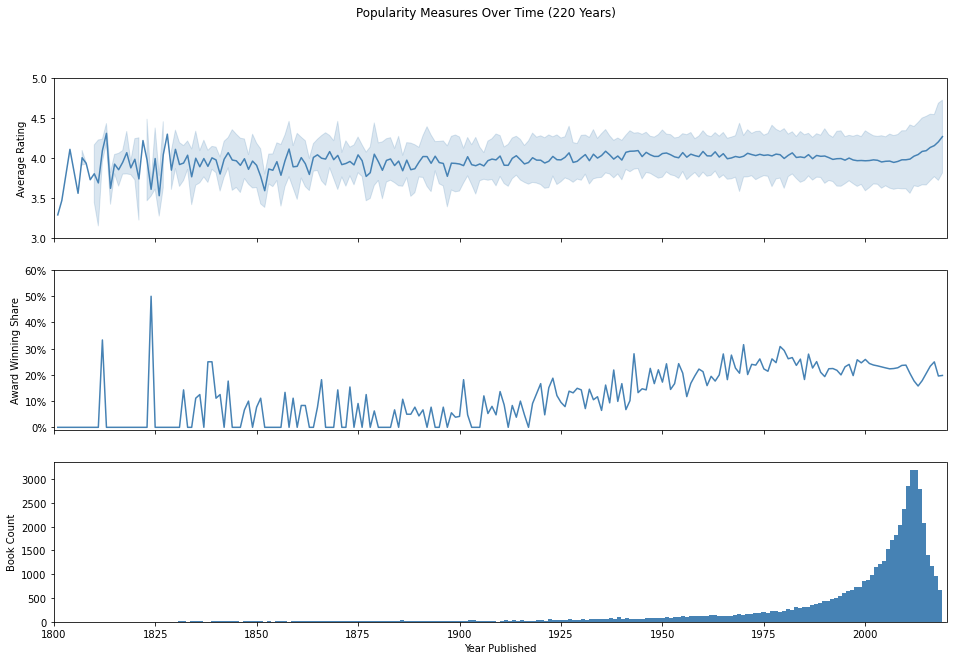

In [112]:
df_grouped = pp.popularity_measures_plot_prep(df_1800_2020, group_by_cols = ['year_published'])

fig, ax = plt.subplots(3, figsize=(16, 10), sharex = True)
fig.suptitle('Popularity Measures Over Time (220 Years)')

df_grouped.plot(ax=ax[0], y='avg_rating_mean', kind='line', color='steelblue', legend = False)
ax[0].fill_between(df_grouped.index, df_grouped['avg_rating_mean'] - df_grouped['avg_rating_std'],
                df_grouped['avg_rating_mean'] + df_grouped['avg_rating_std'],
                alpha = 0.2, color = 'steelblue')
ax[0].set_ylabel('Average Rating')
ax[0].set_ylim(3,5)

df_grouped.plot(ax=ax[1], y='award_winning_share', kind='line', color='steelblue', legend = False)
ax[1].set_ylabel('Award Winning Share')
yticks = ax[1].get_yticks()
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(['{:,.0%}'.format(y) for y in yticks])
ax[1].set_ylim(-0.01,0.6)

#df_1800_2020.hist(ax=ax[2], column = 'year_published', bins=220, color = 'steelblue', grid = False)
ax[2].hist(df_1800_2020['year_published'], bins=220, color = 'steelblue')
ax[2].set_ylabel('Book Count')
ax[2].set_xlabel(df_grouped.index.name.replace('_',' ').title())
ax[2].set_xlim(1800,2020)

plt.show()

**Filter and group by top genres: Focus on the top genres by book count >= 1000.**

In [11]:
df_top_genres = df_1800_2020.groupby('main_genre').filter(lambda x: len(x) >= 1000)

#### Genre Popularity | Visualization
Using df_top_genres (filtered by top genres)

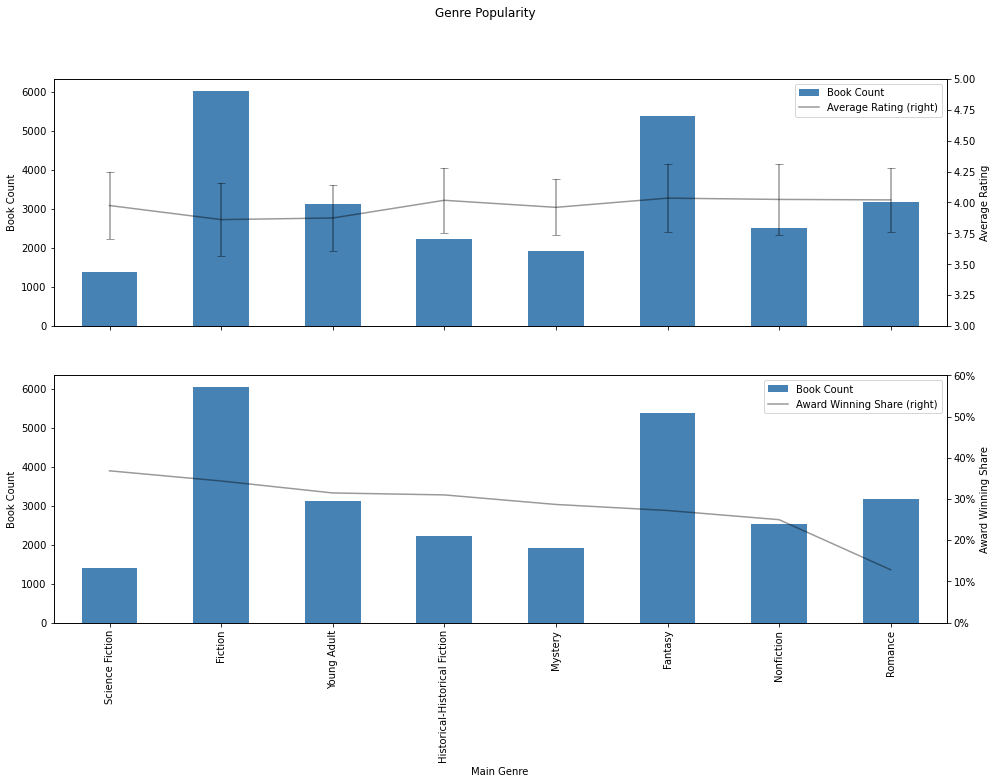

In [81]:
df_grouped = pp.popularity_measures_plot_prep(df_top_genres, group_by_cols = ['main_genre'])
df_grouped = df_grouped.sort_values('award_winning_share', ascending = False)

fig, ax = plt.subplots(2,figsize=(16, 10), sharex = True)
fig.suptitle('Genre Popularity')

df_grouped.plot(ax=ax[0], y='book_count', kind='bar', color='steelblue', label = 'Book Count')
df_grouped.plot(ax=ax[0], y='avg_rating_mean', secondary_y=True, yerr='avg_rating_std', color='black', alpha=0.4, capsize=4, label = 'Average Rating')
ax[0].set_ylabel('Book Count')
ax[0].right_ax.set_ylabel('Average Rating')
ax[0].right_ax.set_ylim(3,5)

df_grouped.plot(ax=ax[1], y='book_count', kind='bar', color='steelblue', label = 'Book Count')
df_grouped.plot(ax=ax[1], y='award_winning_share', secondary_y=True, color='black', alpha=0.4, label = 'Award Winning Share')
ax[1].right_ax.set_ylim(0,0.6)
ax[1].set_ylabel('Book Count')
ax[1].right_ax.set_ylabel('Award Winning Share')
ax[1].set_xlabel(df_grouped.index.name.replace('_',' ').title())
yticks = ax[1].right_ax.get_yticks()
ax[1].right_ax.set_yticks(yticks)
ax[1].right_ax.set_yticklabels(['{:,.0%}'.format(y) for y in yticks])
ax[1].tick_params(axis='x',labelrotation=90)

plt.show()

#### Genre Popularity Over Time | Visualization
Using df_top_genres (filtered by top genres)

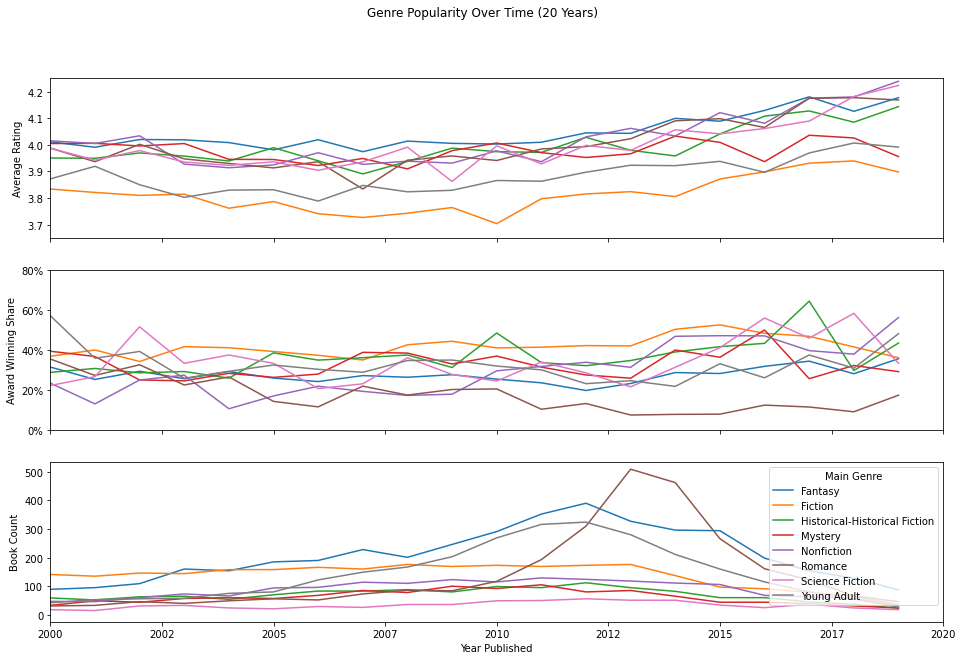

In [72]:
df_grouped = pp.popularity_measures_plot_prep(df_top_genres, group_by_cols = ['year_published','main_genre'])

fig, ax = plt.subplots(3, figsize=(16, 10), sharex = True)
fig.suptitle('Genre Popularity Over Time (20 Years)')

df_grouped['avg_rating_mean'].unstack().plot(ax=ax[0], legend = False)
ax[0].set_ylabel('Average Rating')
ax[0].set_ylim(3.65,4.25)
ax[0].set_xlim(2000,2020)
xticks = ax[0].get_xticks()
ax[0].set_xticks(xticks)
ax[0].set_xticklabels([int(x) for x in xticks])

df_grouped['award_winning_share'].unstack().plot(ax=ax[1], legend = False)
ax[1].set_ylabel('Award Winning Share')
ax[1].set_ylim(0,0.8)
yticks = ax[1].get_yticks()
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(['{:,.0%}'.format(y) for y in yticks])
xticks = ax[1].get_xticks()
ax[1].set_xticks(xticks)
ax[1].set_xticklabels([int(x) for x in xticks])

df_grouped['book_count'].unstack().plot(ax=ax[2], legend = False)
ax[2].set_ylabel('Book Count')
ax[2].set_xlabel(df_grouped.index.names[0].replace('_',' ').title())
xticks = ax[2].get_xticks()
ax[2].set_xticks(xticks)
ax[2].set_xticklabels([int(x) for x in xticks])

plt.legend(title='Main Genre', loc='upper right')

plt.show() 

#### Reader's Rating & Awards | Visualization
Using df_1800_2020 (filtered by year)

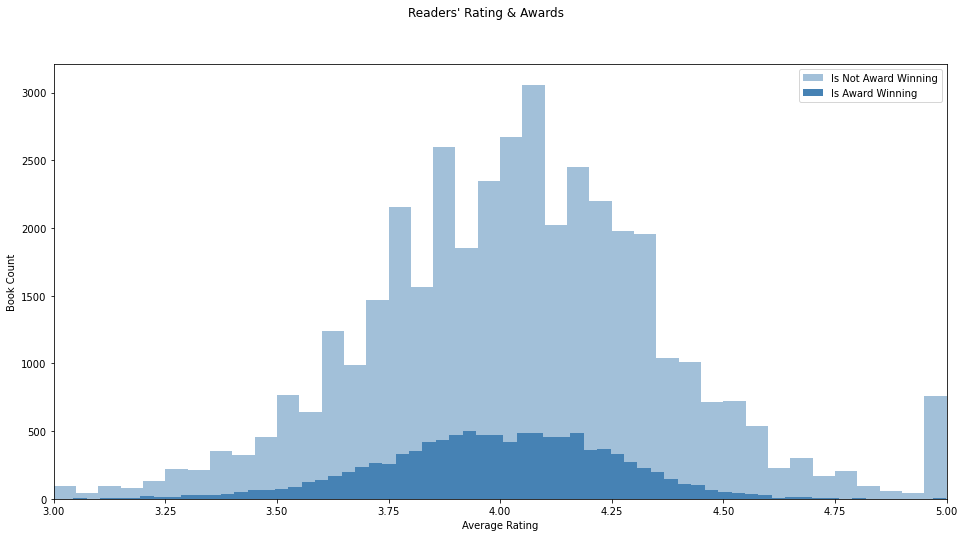

In [73]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle("Readers' Rating & Awards")

ax.hist(df_1800_2020.average_rating[df_1800_2020.is_award_winning == 0], bins=100, color = 'steelblue', alpha = 0.5, label='Is Not Award Winning')
ax.hist(df_1800_2020.average_rating[df_1800_2020.is_award_winning == 1], bins=100, color = 'steelblue', alpha = 1, label='Is Award Winning')
ax.set_ylabel('Book Count')
ax.set_xlabel('Average Rating')
ax.set_xlim([3, 5])

ax.legend(loc='upper right')

plt.show()

#### Relationships of Numerical Variables | Visualization
Using df_1800_2020 (filtered by year)

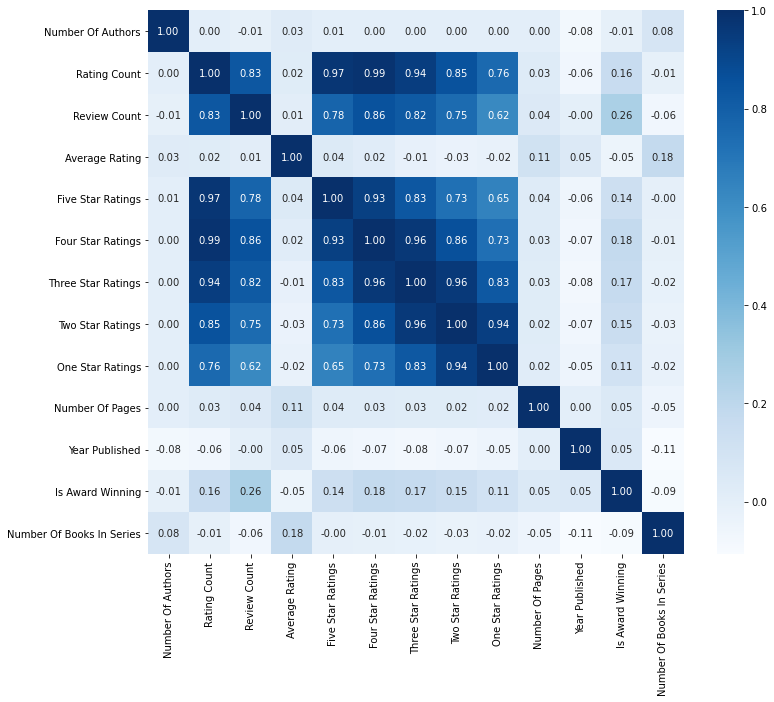

In [61]:
num_df = df_1800_2020.select_dtypes(include=['number']) #all numeric variables
num_cols_lst = num_df.columns

fig, ax = plt.subplots(figsize=(12, 10))

sn.heatmap(df_1800_2020.corr(), annot = True, fmt = '.2f', cmap = 'Blues',
           xticklabels = [x.replace('_',' ').title() for x in num_cols_lst],
           yticklabels = [y.replace('_',' ').title() for y in num_cols_lst])

plt.show()

## Machine Learning (ML) Model
Using df (no additional filter after preprocessing).

### Handling Missing Values & Dummy Encoding (One-Hot)

#### Numerical Variables

In [49]:
num_df = df.select_dtypes(include=['number'])
num_cols_lst = num_df.columns

method_0 = 'number_of_books_in_series'
method_mode = 'year_published'

for col in num_cols_lst:
    if col == method_0:
        df[col].fillna(0, inplace=True)
    elif col == method_mode:
        df[col].fillna((df[col].mode()[0]), inplace=True)
    else:
        df[col].fillna((df[col].mean()), inplace=True)

Index(['number_of_authors', 'rating_count', 'review_count', 'average_rating',
       'five_star_ratings', 'four_star_ratings', 'three_star_ratings',
       'two_star_ratings', 'one_star_ratings', 'number_of_pages',
       'year_published', 'is_award_winning', 'number_of_books_in_series'],
      dtype='object')


#### Categorical Variables

Use one-hot encoding instead of LabelEncoder or OrdinalEncoder from scikit.preprocessing, because the relevant categorical input is on a nominal scale.

In [50]:
cat_df = df.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

for col in cat_cols_lst:
    try:
        # for each categorical variable add dummy variable, drop original column
        print("Processing column " + col)
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)],axis=1)
        print("Done")
    except:
        continue

Processing column main_genre
Done


### Decision Tree Classification

In [51]:
label_col = 'is_award_winning'
X = df.drop(label_col, axis=1)
y = df[label_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=31)

#### Optimal Accuracy | Visualization

Accuracy with maximum depth 1 computed.
Accuracy with maximum depth 2 computed.
Accuracy with maximum depth 3 computed.
Accuracy with maximum depth 4 computed.
Accuracy with maximum depth 5 computed.


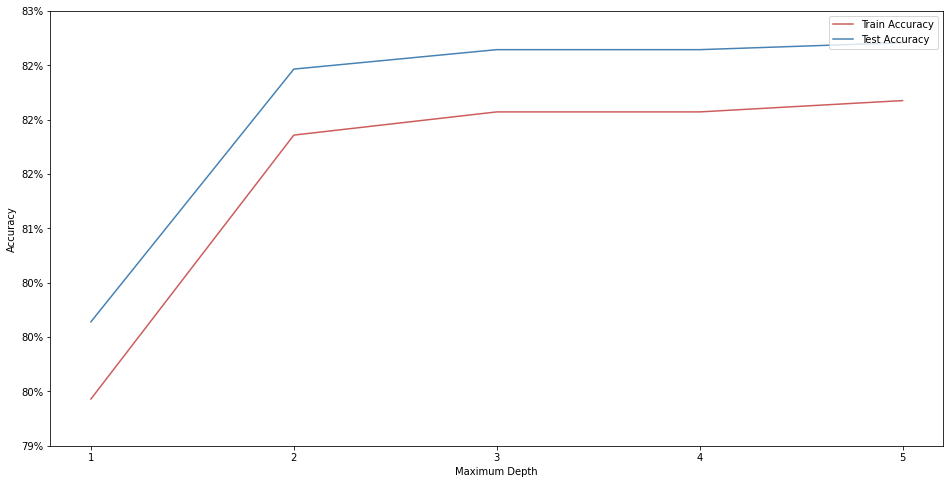

In [9]:
pp.optimal_dt_accuracy(X_train, y_train, X_test, y_test, max_depth_list=[1,2,3,4,5])

#### Decision Tree | Training & Accuracy

In [52]:
# Classifier initialization
clf3 = tree.DecisionTreeClassifier(max_depth = 3)

# Classifier fit
t0 = time()
clf3 = clf3.fit(X_train, y_train)
print("Training time:", round(time() - t0, 3), "s")

# Prediction
t0 = time()
pred_y_test = clf3.predict(X_test)
print("Prediction time:", round(time() - t0, 3), "s")

pred_y_train = clf3.predict(X_train)

# Accuracy
print("Test accuracy:", accuracy_score(y_test, pred_y_test))
print("Train accuracy:", accuracy_score(y_train, pred_y_train))

Training time: 0.868 s
Prediction time: 0.147 s
Test accuracy: 0.8264367816091954
Train accuracy: 0.8207121158214511


#### Decision Tree | Visualization

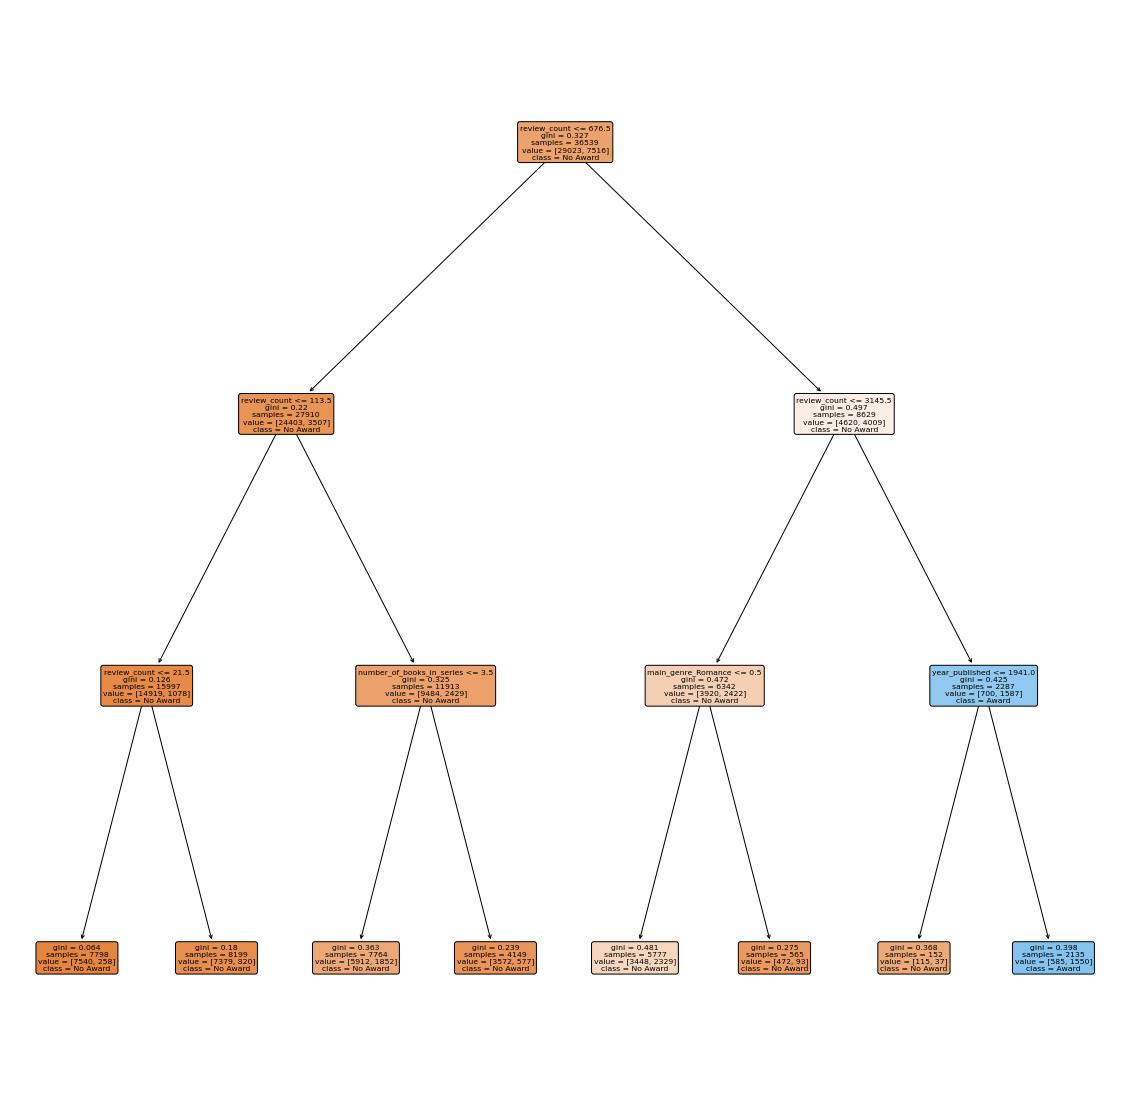

In [53]:
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(clf3, 
               feature_names = X.columns,
               class_names=['No Award', 'Award'],
               filled = True,
               label='all',
               rounded=True)
plt.show()